🚀 Installing required packages...
This may take 3-5 minutes on first run...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✅ All packages installed!

🔧 Using device: cpu

📦 Loading Depth Anything V2 model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

✅ Depth model loaded!

🎨 ADVANCED 2D-TO-3D CONVERTER WITH ART MODE
Features: Layer separation, Art mode, Depth refinement
Perfect for both photos AND stylized artwork!


🎨 ADVANCED 2D to 3D CONVERTER - MAIN MENU

How would you like to provide your image?

1️⃣  Upload an image from your computer
2️⃣  Generate an image from text prompt (AI)
3️⃣  Exit program


Enter your choice (1, 2, or 3): 1

📤 Please upload your image:


Saving WhatsApp Image 2025-11-18 at 11.38.10 PM.jpeg to WhatsApp Image 2025-11-18 at 11.38.10 PM.jpeg
✅ Image loaded: (1080, 736)

🎨 SELECT PROCESSING MODE

📷 PHOTO MODE: For realistic photographs
   - Standard depth estimation
   - Best for: Real photos, portraits, landscapes

🎨 ART MODE: For stylized/illustrated images
   - Advanced layer separation
   - Prevents flat backgrounds
   - Best for: Digital art, illustrations, anime, cartoons


Enter mode (photo/art): photo

📸 Displaying your image...


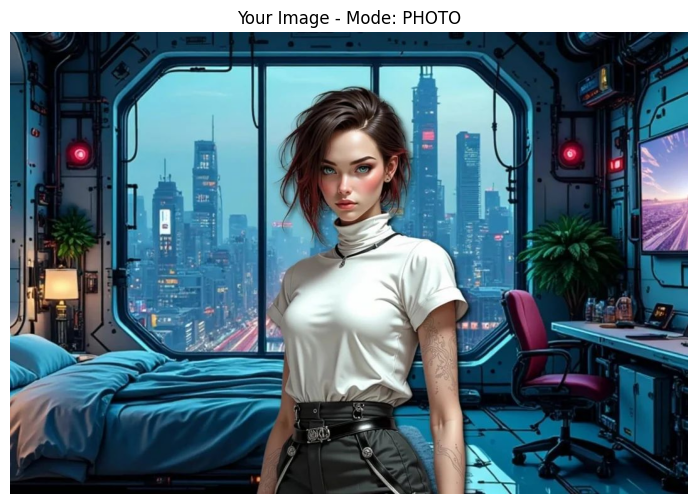

📷 PHOTO MODE
✅ Photo mode processing complete!



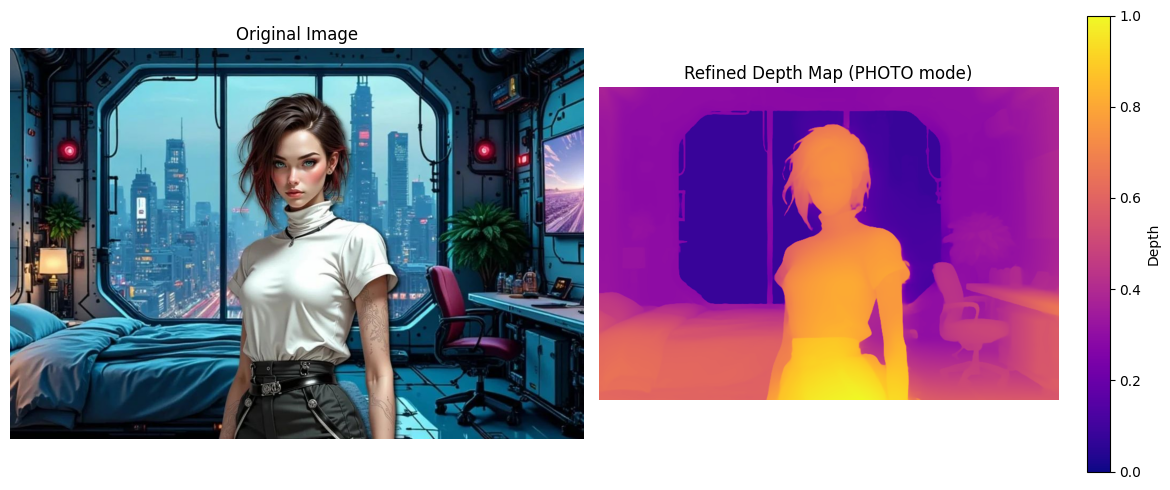

✅ Depth map generated!

🎨 Creating 3D visualization...
Image dimensions: 736x1080
Depth exaggeration: 100.0x
Generating 3D plot with matplotlib...


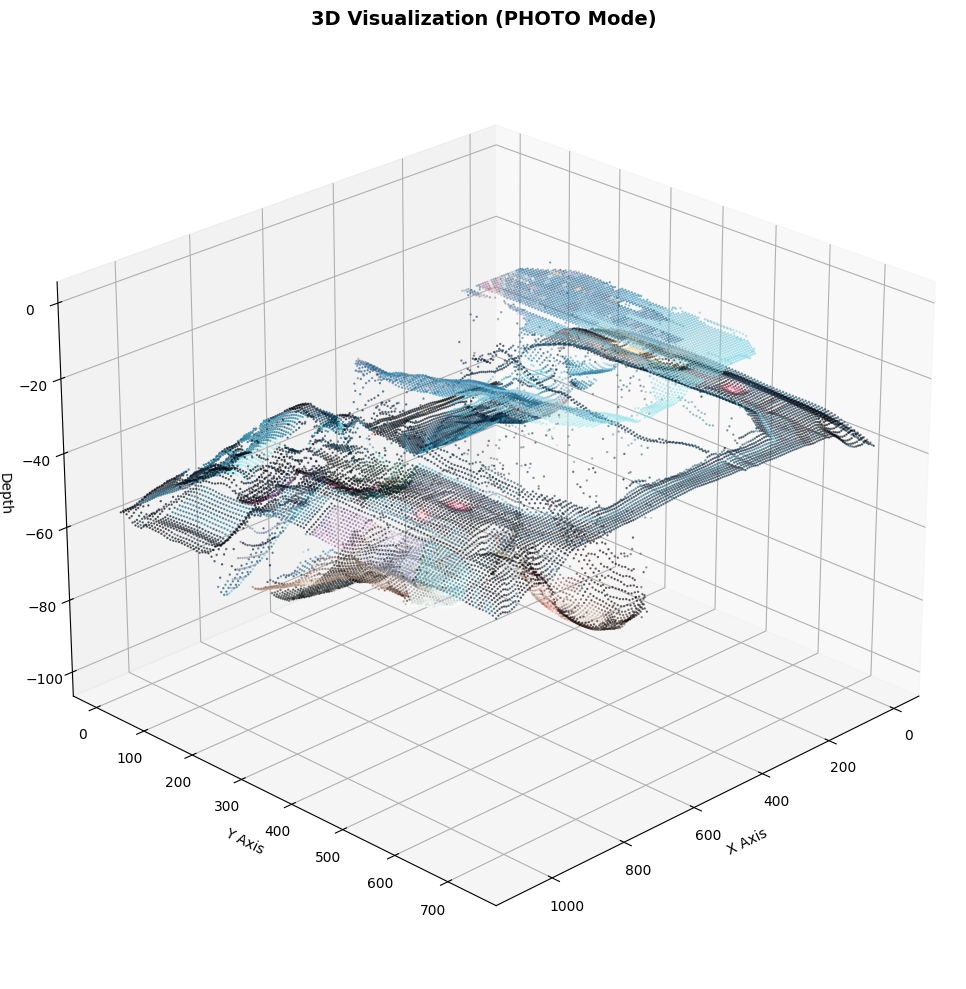

✅ 3D visualization created!

🎭 Creating stereo depth visualizations...


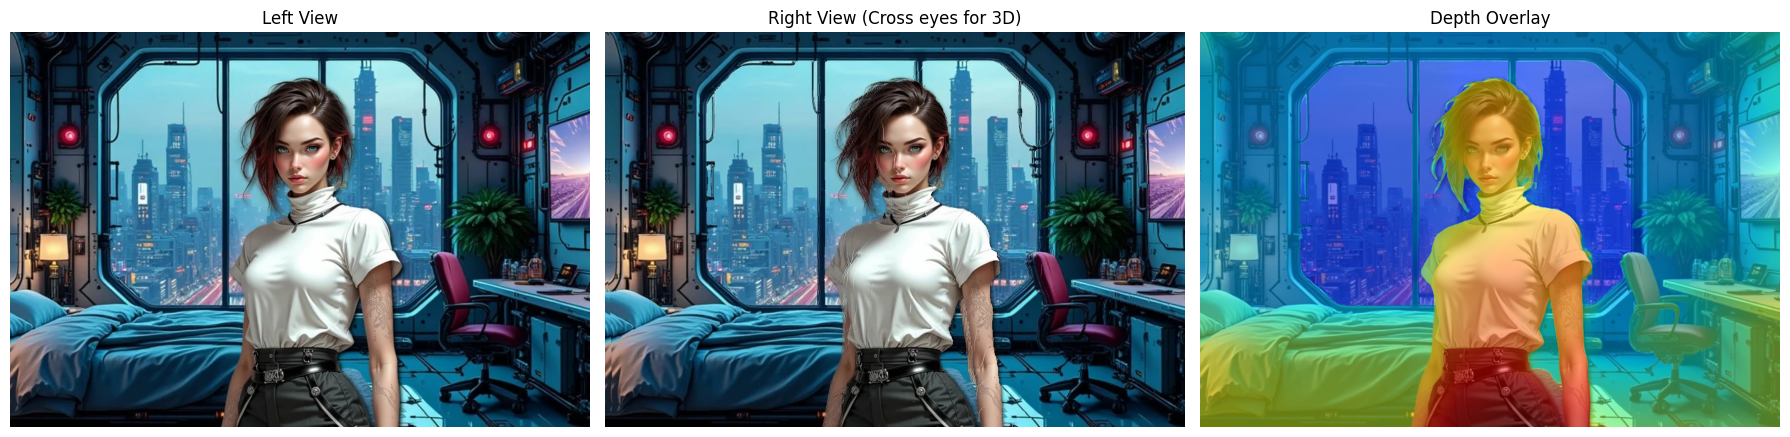

✅ Stereo views created!

📦 Creating 3D mesh files with layer-aware depth...
Mesh quality: high (step size: 3)

✅ Exported 88560 vertices, 175910 faces
✅ Files saved with 'photo' mode settings

📋 WHAT WOULD YOU LIKE TO DO NEXT?

1️⃣  I'm satisfied - Download files and exit
2️⃣  Generate a new image from text prompt
3️⃣  Upload a different image
4️⃣  Reprocess same image (change mode: photo/art)
5️⃣  Go back to main menu


Enter your choice (1-5): 1

⬇️ Downloading all files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ All files downloaded!

🎉 ALL DONE!

📁 Generated Files (PHOTO mode):
   1. output_3d_model_photo.obj - Standard 3D model
   2. output_3d_model_photo.ply - 3D model with colors
   3. output_3d_model_photo.stl - For 3D printing
   4. output_pointcloud_photo.ply - Point cloud

👋 Thank you!


In [1]:
# ========================================
# ADVANCED 2D to 3D CONVERTER WITH ART MODE
# ========================================
# Features: Art Mode, Segmentation, Layer-wise depth, Preprocessing
# Based on client requirements for better stylized image handling

print("🚀 Installing required packages...")
print("This may take 3-5 minutes on first run...\n")

# Install all required packages including segmentation models
!pip install -q torch torchvision transformers diffusers accelerate pillow numpy matplotlib opencv-python plotly trimesh scipy
!pip install -q segment-anything git+https://github.com/facebookresearch/segment-anything.git

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from diffusers import StableDiffusionPipeline
import plotly.graph_objects as go
import cv2
from google.colab import files
import io
import trimesh
from scipy import ndimage

print("✅ All packages installed!\n")

# ========================================
# Initialize Models (Load Once)
# ========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Using device: {device}\n")

# Load Depth Model
print("📦 Loading Depth Anything V2 model...")
depth_model_name = "depth-anything/Depth-Anything-V2-Small-hf"
processor = AutoImageProcessor.from_pretrained(depth_model_name)
depth_model = AutoModelForDepthEstimation.from_pretrained(depth_model_name)
depth_model.to(device)
print(f"✅ Depth model loaded!\n")

# Stable Diffusion will be loaded on demand
sd_pipe = None

# ========================================
# ART MODE FUNCTIONS
# ========================================

def preprocess_art(img):
    """
    Preprocess stylized art images to enhance edges and contrast
    Makes depth estimation more accurate for art/illustrations
    """
    print("   🎨 Applying art preprocessing (sharpening + contrast)...")

    # Convert PIL to numpy if needed
    if isinstance(img, Image.Image):
        img_np = np.array(img)
    else:
        img_np = img.copy()

    # Ensure BGR format for OpenCV
    if len(img_np.shape) == 2:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2BGR)
    elif img_np.shape[2] == 4:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGBA2BGR)
    elif img_np.shape[2] == 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # 1. Sharpen to enhance edges
    blurred = cv2.GaussianBlur(img_np, (0, 0), 3)
    sharpened = cv2.addWeighted(img_np, 1.5, blurred, -0.5, 0)

    # 2. Increase local contrast with CLAHE
    lab = cv2.cvtColor(sharpened, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_enhanced = clahe.apply(L)
    lab_enhanced = cv2.merge((L_enhanced, A, B))
    result = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    # Convert back to RGB
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    return result

def segment_layers(img):
    """
    Segment image into foreground, mid-ground, and background layers
    Uses color-based and depth-based heuristics
    """
    print("   🔍 Segmenting into layers (foreground/mid/background)...")

    if isinstance(img, Image.Image):
        img_np = np.array(img)
    else:
        img_np = img.copy()

    h, w = img_np.shape[:2]

    # Convert to different color spaces for analysis
    hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # Initialize masks
    fg_mask = np.zeros((h, w), dtype=np.uint8)
    mid_mask = np.zeros((h, w), dtype=np.uint8)
    bg_mask = np.zeros((h, w), dtype=np.uint8)

    # Detect edges for object boundaries
    edges = cv2.Canny(gray, 50, 150)
    edges_dilated = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=1)

    # Use center-weighted approach for foreground detection
    center_y, center_x = h // 2, w // 2
    y_coords, x_coords = np.ogrid[:h, :w]

    # Distance from center (normalized)
    dist_from_center = np.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
    dist_from_center = dist_from_center / dist_from_center.max()

    # Foreground: center region with high saturation or contrast
    H, S, V = cv2.split(hsv)
    high_saturation = S > 50
    center_region = dist_from_center < 0.4
    fg_mask = ((high_saturation & center_region) | (edges_dilated > 0 & center_region)).astype(np.uint8) * 255

    # Clean up foreground mask
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

    # Mid-ground: areas with moderate distance and some structure
    mid_region = (dist_from_center >= 0.4) & (dist_from_center < 0.7)
    has_structure = edges_dilated > 0
    mid_mask = (mid_region & has_structure & (fg_mask == 0)).astype(np.uint8) * 255

    # Background: everything else (far from center, low detail)
    bg_mask = ((fg_mask == 0) & (mid_mask == 0)).astype(np.uint8) * 255

    return {
        'fg': fg_mask,
        'mid': mid_mask,
        'bg': bg_mask
    }

def detect_plants(img):
    """
    Detect plants/greenery in the image for pop-out effect
    """
    if isinstance(img, Image.Image):
        img_np = np.array(img)
    else:
        img_np = img.copy()

    hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    # Detect green regions (plants)
    plant_mask = ((h > 35) & (h < 85) & (s > 60) & (v > 40)).astype(np.uint8) * 255

    # Clean up mask
    plant_mask = cv2.morphologyEx(plant_mask, cv2.MORPH_CLOSE, np.ones((10, 10), np.uint8))
    plant_mask = cv2.morphologyEx(plant_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

    return plant_mask

def refine_depth_for_art(depth_raw, seg_masks, img, plant_mask=None):
    """
    Refine depth map with layer-wise adjustments for better 3D separation
    This is the KEY function that fixes flat backgrounds in stylized art
    """
    print("   ✨ Applying layer-wise depth refinement...")

    depth = depth_raw.copy().astype(np.float32)
    depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)  # Normalize 0-1

    fg_mask = seg_masks['fg'] > 0
    mid_mask = seg_masks['mid'] > 0
    bg_mask = seg_masks['bg'] > 0

    h, w = depth.shape

    # 1. FOREGROUND: Push closer to camera (0.1 to 0.4 range)
    if fg_mask.any():
        d_fg = depth[fg_mask]
        depth[fg_mask] = 0.1 + 0.3 * d_fg
        print(f"      - Foreground: {fg_mask.sum()} pixels pushed forward")

    # 2. MID-GROUND: Moderate spread (0.3 to 0.7 range)
    if mid_mask.any():
        d_mid = depth[mid_mask]
        depth[mid_mask] = 0.3 + 0.4 * d_mid
        print(f"      - Mid-ground: {mid_mask.sum()} pixels in middle layer")

    # 3. BACKGROUND: Prevent flattening with artificial parallax
    if bg_mask.any():
        d_bg = depth[bg_mask]

        # Check if background is too flat (low variance)
        if d_bg.var() < 0.001:
            print("      - Background too flat! Adding artificial parallax...")

            # Create gradient: top=far, bottom=closer, slight horizontal variation
            yy, xx = np.mgrid[0:h, 0:w]
            yy_norm = (yy / h).astype(np.float32)
            xx_norm = (xx / w).astype(np.float32)

            # Vertical gradient (top farther) + slight horizontal variation
            parallax = 0.5 + 0.3 * yy_norm + 0.1 * (xx_norm - 0.5)
            depth[bg_mask] = parallax[bg_mask]
        else:
            # Use existing depth but push to back range (0.7 to 1.0)
            depth[bg_mask] = 0.7 + 0.3 * d_bg

        print(f"      - Background: {bg_mask.sum()} pixels with parallax")

    # 4. POP-OUT PLANTS/PROPS: Bring them slightly forward
    if plant_mask is not None and plant_mask.any():
        plant_bool = plant_mask > 0
        depth[plant_bool] = np.maximum(depth[plant_bool] - 0.08, 0.0)
        print(f"      - Plants popped out: {plant_bool.sum()} pixels")

    # 5. Smooth transitions between layers
    depth = cv2.bilateralFilter(depth, 9, 0.05, 5.0)

    # Ensure valid range
    depth = np.clip(depth, 0.0, 1.0)

    return depth

def depth_for_art(img):
    """
    Complete art mode pipeline: preprocess -> segment -> depth -> refine
    """
    print("🎨 ART MODE ACTIVATED")

    # Step 1: Preprocess
    img_preprocessed = preprocess_art(img)

    # Step 2: Segment layers
    seg_masks = segment_layers(img_preprocessed)

    # Step 3: Detect plants for pop-out
    plant_mask = detect_plants(img_preprocessed)

    # Step 4: Get raw depth
    print("   🔍 Estimating depth with enhanced settings...")
    img_pil = Image.fromarray(img_preprocessed)
    inputs = processor(images=img_pil, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = depth_model(**inputs)
        predicted_depth = outputs.predicted_depth

    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=img_pil.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    depth_raw = prediction.squeeze().cpu().numpy()

    # Step 5: Refine depth with layer-wise adjustments
    depth_refined = refine_depth_for_art(depth_raw, seg_masks, img_preprocessed, plant_mask)

    print("✅ Art mode processing complete!\n")

    return depth_refined, seg_masks, img_preprocessed

def depth_for_photo(img):
    """
    Standard photo mode: direct depth estimation
    """
    print("📷 PHOTO MODE")

    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(img)
    else:
        img_pil = img

    inputs = processor(images=img_pil, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = depth_model(**inputs)
        predicted_depth = outputs.predicted_depth

    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=img_pil.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    depth_map = prediction.squeeze().cpu().numpy()
    depth_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    print("✅ Photo mode processing complete!\n")

    return depth_normalized, None, np.array(img_pil)

# ========================================
# FUNCTION: Load Stable Diffusion
# ========================================
def load_stable_diffusion():
    global sd_pipe
    if sd_pipe is None:
        print("\n📦 Loading Stable Diffusion model...")
        print("(This will download ~4GB on first run)")

        model_id = "runwayml/stable-diffusion-v1-5"
        sd_pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            safety_checker=None
        )
        sd_pipe = sd_pipe.to(device)

        if device == "cuda":
            sd_pipe.enable_attention_slicing()

        print(f"✅ Stable Diffusion loaded on {device}!\n")
    return sd_pipe

# ========================================
# FUNCTION: Display Main Menu
# ========================================
def display_main_menu():
    print("\n" + "="*60)
    print("🎨 ADVANCED 2D to 3D CONVERTER - MAIN MENU")
    print("="*60)
    print("\nHow would you like to provide your image?")
    print("\n1️⃣  Upload an image from your computer")
    print("2️⃣  Generate an image from text prompt (AI)")
    print("3️⃣  Exit program")
    print("\n" + "="*60)

    choice = input("\nEnter your choice (1, 2, or 3): ").strip()
    return choice

# ========================================
# FUNCTION: Ask for Art Mode
# ========================================
def ask_art_mode():
    print("\n" + "="*60)
    print("🎨 SELECT PROCESSING MODE")
    print("="*60)
    print("\n📷 PHOTO MODE: For realistic photographs")
    print("   - Standard depth estimation")
    print("   - Best for: Real photos, portraits, landscapes")
    print("\n🎨 ART MODE: For stylized/illustrated images")
    print("   - Advanced layer separation")
    print("   - Prevents flat backgrounds")
    print("   - Best for: Digital art, illustrations, anime, cartoons")
    print("\n" + "="*60)

    mode = input("\nEnter mode (photo/art): ").strip().lower()

    if mode in ['art', 'a']:
        return 'art'
    else:
        return 'photo'

# ========================================
# FUNCTION: Display Feedback Menu
# ========================================
def display_feedback_menu():
    print("\n" + "="*60)
    print("📋 WHAT WOULD YOU LIKE TO DO NEXT?")
    print("="*60)
    print("\n1️⃣  I'm satisfied - Download files and exit")
    print("2️⃣  Generate a new image from text prompt")
    print("3️⃣  Upload a different image")
    print("4️⃣  Reprocess same image (change mode: photo/art)")
    print("5️⃣  Go back to main menu")
    print("\n" + "="*60)

    choice = input("\nEnter your choice (1-5): ").strip()
    return choice

# ========================================
# FUNCTION: Upload Image
# ========================================
def upload_image():
    print("\n📤 Please upload your image:")
    uploaded = files.upload()

    image_path = list(uploaded.keys())[0]
    image = Image.open(image_path).convert("RGB")

    print(f"✅ Image loaded: {image.size}")
    return image, "uploaded"

# ========================================
# FUNCTION: Generate Image from Text
# ========================================
def generate_image_from_text():
    pipe = load_stable_diffusion()

    print("\n" + "="*60)
    print("💡 Examples of prompts you can try:")
    print("  - 'A majestic dragon flying over mountains'")
    print("  - 'A futuristic sports car, highly detailed'")
    print("  - 'A cute robot character, 3D render style'")
    print("  - 'An ancient temple in the jungle'")
    print("  - 'Girl in anime style room with plants and city view'")
    print("="*60)

    user_prompt = input("\n✍️ Enter your description: ")

    print(f"\n📝 Your prompt: '{user_prompt}'")
    print("\n🎨 Generating image... (this may take 30-60 seconds)")

    image = pipe(
        user_prompt,
        num_inference_steps=30,
        guidance_scale=7.5,
        height=512,
        width=512
    ).images[0]

    print("✅ Image generated successfully!")
    image.save("generated_image.png")
    print("💾 Image saved as 'generated_image.png'")

    return image, user_prompt

# ========================================
# FUNCTION: Process Image to 3D
# ========================================
def process_image_to_3d(image, source_info, mode='photo'):
    # Display Original Image
    print("\n📸 Displaying your image...")
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.title(f"Your Image - Mode: {mode.upper()}")
    plt.axis('off')
    plt.show()

    # Get depth based on mode
    if mode == 'art':
        depth_normalized, seg_masks, processed_img = depth_for_art(image)

        # Show segmentation masks
        if seg_masks is not None:
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            axes[0].imshow(image)
            axes[0].set_title('Original')
            axes[0].axis('off')

            axes[1].imshow(seg_masks['fg'], cmap='hot')
            axes[1].set_title('Foreground Layer')
            axes[1].axis('off')

            axes[2].imshow(seg_masks['mid'], cmap='hot')
            axes[2].set_title('Mid-ground Layer')
            axes[2].axis('off')

            axes[3].imshow(seg_masks['bg'], cmap='hot')
            axes[3].set_title('Background Layer')
            axes[3].axis('off')

            plt.tight_layout()
            plt.show()
    else:
        depth_normalized, seg_masks, processed_img = depth_for_photo(image)

    # Display depth map
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(depth_normalized, cmap='plasma')
    plt.colorbar(label='Depth')
    plt.title(f"Refined Depth Map ({mode.upper()} mode)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("✅ Depth map generated!")

    # Create 3D Point Cloud with EXAGGERATED DEPTH for art mode
    print("\n🎨 Creating 3D visualization...")

    # Adjust depth exaggeration based on mode
    depth_exaggeration = 150.0 if mode == 'art' else 100.0

    max_points = 20000
    img_array = np.array(image)
    h, w = depth_normalized.shape

    print(f"Image dimensions: {h}x{w}")
    print(f"Depth exaggeration: {depth_exaggeration}x")

    step = max(1, int(np.sqrt(h * w / max_points)))

    y_coords, x_coords = np.mgrid[0:h:step, 0:w:step]

    z = depth_normalized[y_coords, x_coords].flatten()
    colors_rgb = img_array[y_coords, x_coords].reshape(-1, 3)
    x = x_coords.flatten()
    y = y_coords.flatten()

    y = h - y
    z = -z * depth_exaggeration

    print("Generating 3D plot with matplotlib...")

    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(x, y, z,
                        c=colors_rgb/255.0,
                        marker='.',
                        s=2,
                        alpha=0.6,
                        depthshade=True)

    ax.set_xlabel('X Axis', fontsize=10)
    ax.set_ylabel('Y Axis', fontsize=10)
    ax.set_zlabel('Depth', fontsize=10)
    ax.set_title(f'3D Visualization ({mode.upper()} Mode)', fontsize=14, fontweight='bold')

    ax.view_init(elev=25, azim=45)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✅ 3D visualization created!")

    # Create Alternative Depth Views
    print("\n🎭 Creating stereo depth visualizations...")

    offset = int(w * 0.02)
    depth_shift = (depth_normalized * offset).astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    img_left = np.array(image)
    img_right = np.array(image)

    for i in range(h):
        for j in range(w):
            shift = depth_shift[i, j]
            if j + shift < w:
                img_right[i, j + shift] = img_left[i, j]

    axes[0].imshow(img_left)
    axes[0].set_title('Left View')
    axes[0].axis('off')

    axes[1].imshow(img_right)
    axes[1].set_title('Right View (Cross eyes for 3D)')
    axes[1].axis('off')

    axes[2].imshow(image)
    axes[2].imshow(depth_normalized, cmap='jet', alpha=0.5)
    axes[2].set_title('Depth Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    print("✅ Stereo views created!")

    # Create and Export 3D Mesh Files
    print("\n📦 Creating 3D mesh files with layer-aware depth...")

    mesh_quality = 'high'

    if mesh_quality == 'low':
        mesh_step = max(2, int(np.sqrt(h * w / 5000)))
    elif mesh_quality == 'medium':
        mesh_step = max(2, int(np.sqrt(h * w / 20000)))
    else:
        mesh_step = max(1, int(np.sqrt(h * w / 50000)))

    print(f"Mesh quality: {mesh_quality} (step size: {mesh_step})")

    y_mesh_coords, x_mesh_coords = np.mgrid[0:h:mesh_step, 0:w:mesh_step]
    mesh_h, mesh_w = y_mesh_coords.shape

    z_mesh_data = depth_normalized[y_mesh_coords, x_mesh_coords]
    colors_mesh_data = img_array[y_mesh_coords, x_mesh_coords]

    scale_xy = 1.0
    scale_z = depth_exaggeration

    vertices = []
    colors_vertex = []

    for i in range(mesh_h):
        for j in range(mesh_w):
            x_coord = x_mesh_coords[i, j] * scale_xy
            y_coord = (h - y_mesh_coords[i, j]) * scale_xy
            z_coord = -z_mesh_data[i, j] * scale_z

            vertices.append([x_coord, y_coord, z_coord])
            colors_vertex.append(colors_mesh_data[i, j])

    vertices = np.array(vertices)
    colors_vertex = np.array(colors_vertex)

    faces = []
    for i in range(mesh_h - 1):
        for j in range(mesh_w - 1):
            idx = i * mesh_w + j
            faces.append([idx, idx + 1, idx + mesh_w])
            faces.append([idx + 1, idx + mesh_w + 1, idx + mesh_w])

    faces = np.array(faces)

    mesh = trimesh.Trimesh(
        vertices=vertices,
        faces=faces,
        vertex_colors=colors_vertex,
        process=False
    )

    obj_filename = f'output_3d_model_{mode}.obj'
    ply_filename = f'output_3d_model_{mode}.ply'
    stl_filename = f'output_3d_model_{mode}.stl'
    pc_filename = f'output_pointcloud_{mode}.ply'

    mesh.export(obj_filename)
    mesh.export(ply_filename)
    mesh.export(stl_filename)

    pointcloud = trimesh.PointCloud(vertices=vertices, colors=colors_vertex)
    pointcloud.export(pc_filename)

    print(f"\n✅ Exported {len(vertices)} vertices, {len(faces)} faces")
    print(f"✅ Files saved with '{mode}' mode settings")

    return {
        'obj': obj_filename,
        'ply': ply_filename,
        'stl': stl_filename,
        'pointcloud': pc_filename,
        'image': image,
        'source': source_info,
        'mode': mode
    }

# ========================================
# FUNCTION: Download All Files
# ========================================
def download_files(result_data):
    print("\n⬇️ Downloading all files...")
    try:
        if isinstance(result_data['source'], str) and result_data['source'] != "uploaded":
            files.download('generated_image.png')
        files.download(result_data['obj'])
        files.download(result_data['ply'])
        files.download(result_data['stl'])
        files.download(result_data['pointcloud'])
        print("✅ All files downloaded!")
    except Exception as e:
        print(f"⚠️ Auto-download issue: {e}")

    print("\n" + "="*60)
    print("🎉 ALL DONE!")
    print("="*60)
    print(f"\n📁 Generated Files ({result_data['mode'].upper()} mode):")
    print(f"   1. {result_data['obj']} - Standard 3D model")
    print(f"   2. {result_data['ply']} - 3D model with colors")
    print(f"   3. {result_data['stl']} - For 3D printing")
    print(f"   4. {result_data['pointcloud']} - Point cloud")

# ========================================
# MAIN PROGRAM LOOP
# ========================================
def main():
    print("="*60)
    print("🎨 ADVANCED 2D-TO-3D CONVERTER WITH ART MODE")
    print("="*60)
    print("Features: Layer separation, Art mode, Depth refinement")
    print("Perfect for both photos AND stylized artwork!\n")

    current_result = None
    current_image = None
    current_source = None
    current_mode = None

    while True:
        main_choice = display_main_menu()

        if main_choice == "1":
            current_image, current_source = upload_image()
            current_mode = ask_art_mode()
            current_result = process_image_to_3d(current_image, current_source, current_mode)

        elif main_choice == "2":
            current_image, current_source = generate_image_from_text()
            current_mode = ask_art_mode()
            current_result = process_image_to_3d(current_image, current_source, current_mode)

        elif main_choice == "3":
            print("\n👋 Thank you for using Advanced 2D-to-3D Converter!")
            print("Goodbye! 🎨")
            break

        else:
            print("\n❌ Invalid choice. Please select 1, 2, or 3.")
            continue

        while True:
            feedback_choice = display_feedback_menu()

            if feedback_choice == "1":
                download_files(current_result)
                print("\n👋 Thank you!")
                return

            elif feedback_choice == "2":
                current_image, current_source = generate_image_from_text()
                current_mode = ask_art_mode()
                current_result = process_image_to_3d(current_image, current_source, current_mode)

            elif feedback_choice == "3":
                current_image, current_source = upload_image()
                current_mode = ask_art_mode()
                current_result = process_image_to_3d(current_image, current_source, current_mode)

            elif feedback_choice == "4":
                print("\n🔄 Reprocessing with different mode...")
                new_mode = 'art' if current_mode == 'photo' else 'photo'
                print(f"Switching from {current_mode.upper()} to {new_mode.upper()} mode")
                current_mode = new_mode
                current_result = process_image_to_3d(current_image, current_source, current_mode)

            elif feedback_choice == "5":
                break

            else:
                print("\n❌ Invalid choice. Please select 1-5.")

# Run the program
main()